# Анализ пользовательского поведения в мобильном приложении

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения. 

**Основные цели:**
- Изучить воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента. Выяснить, какой шрифт лучше.

**План работы:**
1. Загрузить необходимые библиотеки и данные
2. Провести предобработку данных
3. Провести анализ событий в логе
4. Изучить воронку событий 
5. Изучить результаты эксперимента по изменению шрифта
6. Сделать выводы

## Загрузка файла с данными и изучение общей информации

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
#выведем основную информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В таблице 244126 строк и 4 столбца:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Тип данных в столбце EventTimestamp не будем менять, так как добавим отдельные столбцы с датой и временем. Также приведем в порядок названия стобцов:приведем все к змеиному регистру. Проверим данные на наличие пропусков и дубликатов.  

## Предобработка данных

In [4]:
#изменим названия столбцов 
data.columns = ['event_name','device_id_hash','event_timestamp', 'exp_id']
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [5]:
#проверим данные на наличие пропусков
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

В данных нет пропущенных значений, перейдем к рассмотрению дубликатов.

In [6]:
#посчитаем сколько дубликатов в таблице 
data.duplicated().sum()

413

В таблице целых 413 явных дубликатов. Удалим их, сбросив индексы.

In [7]:
#удалим дуликаты
data = data.drop_duplicates().reset_index(drop=True)

In [8]:
data.duplicated().sum()

0

Явные дубликаты удалены. Посмотрим также уникальные значения в столбце event_name:

In [9]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Здесь все в порядке, неявных дубликатов нет. Добавим столбец даты и времени, а также отдельный столбец дат.

In [10]:
data['datetime'] = [dt.fromtimestamp(x) for x in data['event_timestamp']]
data['date'] = data['datetime'].dt.normalize()
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Также необходимо проверить попадают ли одни и те же пользователи сразу в несколько групп. 

In [12]:
users_246_7_8 = data.groupby('device_id_hash').agg({'exp_id' : 'nunique'}).query('exp_id>1').count()
users_246_7_8

exp_id    0
dtype: int64

Сгруппировав данные по идентификатору пользователя, мы посчитали во сколько уникальных групп входит каждый пользователь. В исходных данных нет пользователей, которые попадают сразу в несколько групп.

## Анализ событий в логе


Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
Много ли событий и пользователей вы потеряли, отбросив старые данные?
Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

### Подсчет событий и пользователей в логе

In [13]:
print('Кол-во событий в логе:', data.shape[0])

Кол-во событий в логе: 243713


В логе 243723 событий, 413 повторяющихся мы уже убрали. 

In [14]:
print('Кол-во пользователей в логе:', data['device_id_hash'].nunique())

Кол-во пользователей в логе: 7551


В логе всего 7551 уникальный пользователь. Значительно меньше чем событий, значит на каждого приходится далеко не одно событие. Посчитаем, сколько в среднем событий приходится на пользователя: 

In [15]:
print('Кол-во событий на пользователя:', round(data.shape[0]/data['device_id_hash'].nunique(),2))

Кол-во событий на пользователя: 32.28


В среднем на одного пользователя приходится около 32 событий.

### Анализ периода исследования

В этом блоке узнаем, данными за какой период мы располагаете? Найдем максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Проанализируем, можно ли быть уверенным, что у нас одинаково полные данные за весь период? Определим, с какого момента данные полные и отбросим более старые. Определим, данными за какой период времени мы располагаете на самом деле? Посмотрим, много ли событий и пользователей мы потеряли, отбросив старые данные? Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [16]:
min_date = data['date'].min()
max_date = data['date'].max()
print('Минимальная дата:',min_date)
print('Максимальная дата:', max_date)

Минимальная дата: 2019-07-25 00:00:00
Максимальная дата: 2019-08-07 00:00:00


Мы располагаем данными за период с 25 июля 2019 года по 7 августа 2019 года. Посмотрим сколько событий приходится на каждый из существующих дней и построим столбчатую диаграмму, отражающую количество событий в зависимости от времени в разрезе групп.

In [17]:
data['date'].value_counts()

2019-08-01    36141
2019-08-05    36058
2019-08-06    35788
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-07    31096
2019-07-31     2030
2019-07-30      412
2019-07-29      184
2019-07-28      105
2019-07-27       55
2019-07-26       31
2019-07-25        9
Name: date, dtype: int64

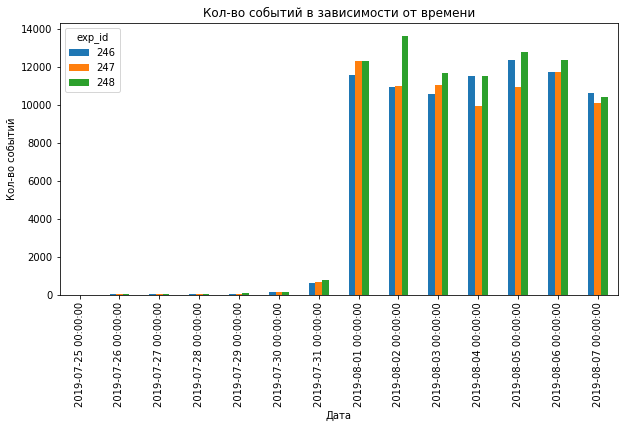

In [18]:
date_count_events = data.pivot_table(index='date',columns='exp_id', values='device_id_hash', aggfunc='count')
date_count_events.plot(kind = 'bar', figsize = (10,5), fontsize = 10)
plt.title('Кол-во событий в зависимости от времени', fontsize=12)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Кол-во событий', fontsize=10)
plt.show()

По графику хорошо видно, что данных за июль совсем мало. Можем сделать вывод, что полные данные у нас есть только за август. Определим 1 августа как границу и отбросим более старые данные. Создадим новый датафрейм

In [19]:
new_data = data.query('date >= "2019-08-01"')
new_data.head()

,event_name,device_id_hash,event_timestamp,exp_id,datetime,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [20]:
new_min_date = new_data['date'].min()
new_max_date = new_data['date'].max()
print('Минимальная дата:',new_min_date)
print('Максимальная дата:', new_max_date)

Минимальная дата: 2019-08-01 00:00:00
Максимальная дата: 2019-08-07 00:00:00


Получается, что на самом деле мы располагаем данными за период с 1 по 7 августа 2019 года.

Посмотрим, много ли событий мы потеряли, отбросив старые данные? 

In [21]:
print('Кол-во событий в начале:', data.shape[0])
print('Кол-во событий сейчас:', new_data.shape[0])
print('Потерянные события:', data.shape[0] - new_data.shape[0])
print('Доля потерянных событий:', round((data.shape[0] - new_data.shape[0]) / data.shape[0] * 100, 2))

Кол-во событий в начале: 243713
Кол-во событий сейчас: 240887
Потерянные события: 2826
Доля потерянных событий: 1.16


Мы потеряли чуть больше 1% событий (1.16%), но учитывая, что эти данные неполные и не совсем актуальные, то это неплохой результат.  

Посмотрим, сколько пользователей мы потеряли:

In [22]:
print('Кол-во пользователей в начале:', data['device_id_hash'].nunique())
print('Кол-во пользователей сейчас:', new_data['device_id_hash'].nunique())
print('Потерянные пользователи:', data['device_id_hash'].nunique() - new_data['device_id_hash'].nunique())
print('Доля потерянных пользователей:', round((data['device_id_hash'].nunique() - new_data['device_id_hash'].nunique()) / data['device_id_hash'].nunique() * 100, 2))

Кол-во пользователей в начале: 7551
Кол-во пользователей сейчас: 7534
Потерянные пользователи: 17
Доля потерянных пользователей: 0.23


Было потеряно всего 17 пользователей, это очень мало на фоне общего числа. Всего 0.23%

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп. Посчитаем количество событий в каждой группе:


In [23]:
new_data['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

В каждой группе довольно много событий, разница в их количестве незначительна. Посчитаем количество уникальных пользователей в каждой группе. 

In [24]:
new_data.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Отлично, все на месте. Можем продолжать!

## Изучение воронки событий

### Анализ событий в логах

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [25]:
new_data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Всего в логах 5 событий:
- Главная страница 
- Страница с предложениями
- Корзина
- Оформление 
- Руководство 

Самое часто встречающееся событие - посещение главной страницы, почти половина от общего числа событий. На втором месте - страница с предложениями - 46333 события, далее переходы в корзину - 42303 события. На оформление заказов приходится почти 34 тыс. событий. Самое редкое действие - просмотр руководства - всего 1005 событий.   


### Анализ количества пользователей на событие

Посчитаем, сколько пользователей совершали каждое из событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [26]:
us_count = new_data.groupby('event_name').agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash',ascending=False)
us_count.columns = ['user_count']
us_count['event1'] = us_count['user_count'] / new_data['device_id_hash'].nunique()
us_count

,user_count,event1
event_name,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


Больше всего пользователей приходится на главную страницу, то есть это почти все пользователи (около 98,5%). 4593 пользователя переходят на страницу с предложениями - около 61 процента. Практически 50% пользователей переходят к корзине и 47% доходят до оформления заказа. Всего 11% пользователей просматривают руководство.    

Можно предположить, что события происходят как раз в таком порядке:
1. Главная страница
2. Страница с предложениями
3. Корзина
4. Оформление заказа

Просмотр руководства сильно выделяется среди остальных событий. Почти 90% пользователей его игнорируют, поэтому не будем учитывать его при расчёте воронки.

### Анализ воронки 

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
Узнаем, на каком шаге теряете больше всего пользователей, а также найдем долю пользователей, которые доходят от первого события до оплаты?

In [27]:
us_count = us_count.query('event_name != "Tutorial"')
us_count['dolya'] = (us_count['user_count'].pct_change()) + 1
us_count

/tmp/ipykernel_436/3253003200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_count['dolya'] = (us_count['user_count'].pct_change()) + 1


,user_count,event1,dolya
event_name,,,
MainScreenAppear,7419,0.984736,NaN
OffersScreenAppear,4593,0.609636,0.619086
CartScreenAppear,3734,0.495620,0.812976
PaymentScreenSuccessful,3539,0.469737,0.947777


Таким образом, на второй шаг-страница предложений- переходят около 62% от числа пользователей, посетивших главную страницу. 81% из них дальше переходят в корзину. Из корзины 95%! пользователей переходят к оформлению заказа.

Больше всего пользователей теряется на первом шаге при переходе с главного экрана к предложениям. Это может быть из-за того, что какая-то часть пользователей вообще не посещает главную страницу (те самые 2 процента), а сразу попадают на страницу с предложением. Или из-за нефункциональной главной страницы, по которой неудобно переходить дальше.  

Найдем долю пользователей, которые доходят от первого события до оплаты:

In [28]:
us_count['start_end'] = us_count['user_count'] / us_count['user_count'][0] 
us_count

/tmp/ipykernel_436/2635003463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_count['start_end'] = us_count['user_count'] / us_count['user_count'][0]


,user_count,event1,dolya,start_end
event_name,,,,
MainScreenAppear,7419,0.984736,NaN,1.000000
OffersScreenAppear,4593,0.609636,0.619086,0.619086
CartScreenAppear,3734,0.495620,0.812976,0.503302
PaymentScreenSuccessful,3539,0.469737,0.947777,0.477018


С самого начала и до последнего события доходят около 48%. В принципе, это было заметно уже в начале анализа воронки, но сейчас мы получили более точные данные. 

Таким образом, мы выделили 4 события в воронке: главный экран - каталог - корзина - оформление. Была посчитана доля пользователей, которая проходит на следующий шаг воронки: с главной страницы к каталогу переходят 62%, с каталога в корзину - 81% и с корзины переходят к оформлению - около 95%. Из этого можно сделать вывод, что большая часть теряется уже на втором шаге при переходе к странице с предложениями, а дальше люди уже довольно стабильно переходят к оплате. 

Если рассматривать долю пользователей, которые доходят от первого события до оплаты, то хорошо заметно, что при переходе с первого на второй шаг теряется около 38% от начальных пользователей. Дальше от перехода из каталога в корзину пропадает еще 12% пользователей. И при переходе к последнему событию теряются всего 2%. В итоге с главного экрана и до корзины доходят чуть меньше половины пользователей, а точнее 47.7% пользователей.

## Анализ результатов эксперимента

### Количество пользователей в каждой экспериментальной группе

Посчитаем, сколько уникальных пользователей в каждой из трех групп:

In [29]:
total_us = new_data.groupby('exp_id')['device_id_hash'].nunique().sort_values(ascending=False)
total_us

exp_id
248    2537
247    2513
246    2484
Name: device_id_hash, dtype: int64

Больше всего пользователей из экспериментальной группы 248, далее идут контрольные группы 247 и 246. В принципе, отличия в количестве пользователей незначительны.

### Проверка контрольных групп

У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

In [30]:
#подготовим данные 
aa_test = new_data.query('event_name != "Tutorial"').pivot_table(
    index='exp_id', columns='event_name', values='device_id_hash', aggfunc='nunique'
)
aa_test = aa_test.merge(total_us, on='exp_id', how='left')

aa_test['dolyaMainScreen'] = aa_test['MainScreenAppear'] / aa_test['device_id_hash']
aa_test

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,device_id_hash,dolyaMainScreen
exp_id,,,,,,
246,1266,2450,1542,1200,2484,0.986312
247,1238,2476,1520,1158,2513,0.985277
248,1230,2493,1531,1181,2537,0.982657


Значения отличаются друг от друга, но не значительно, в пределах 40 уникальных пользователей. Далее проверим конкретные гипотезы для каждого из события относительно групп 246 и 247.

Мы будем проводить несколько проверок гипотез о равенстве долей. Напишем функцию для z-критерия для оптимизации процесса.

In [31]:
def z_kriterii (group1, group2, event, alpha):
    success = np.array([new_data.query('event_name == @event and exp_id == @group1').device_id_hash.nunique(),
                           new_data.query('event_name == @event and exp_id == @group2').device_id_hash.nunique()])
    trials = np.array([new_data.query('exp_id == @group1').device_id_hash.nunique(),
                           new_data.query('exp_id == @group2').device_id_hash.nunique()])
    # пропорция успехов в первой группе:
    p1 = success[0] / trials[0]
    # пропорция успехов во второй группе:
    p2 = success[1] / trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Сейчас мы будем проверять находят ли статистические критерии разницу между выборками 246 и 247. 

Нулевая гипотеза: Разница между долями в двух группах отсуствует. Альтернативая гипотеза - разница между долями статистически значима. 

В качестве уровня статистической значимости возьмем 0,05.

In [32]:
alpha = 0.05
group1 = 246
group2 = 247

In [33]:
#1 событие - MainScreenAppear
print('MainScreenAppear')
event = 'MainScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#2 событие - OffersScreenAppear
print('OffersScreenAppear')
event = 'OffersScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#3 событие - CartScreenAppear
print('CartScreenAppear')
event = 'CartScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#4 событие - PaymentScreenSuccessful
print('PaymentScreenSuccessful')
event = 'PaymentScreenSuccessful'
z_kriterii (group1, group2, event, alpha)
print()

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Во всех случаях р-значение значительно больше уровня значимости. Не можем отвергнуть нулевую гипотезу, то есть статистически значимой разницы между группами нет. 

### Результаты проверки контрольных групп

Теперь выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Узнаем, можно ли сказать, что разбиение на группы работает корректно?

Ранее мы уже обозначали, что самое популярное событие - это посещение главной страницы. Кол-во пользователей, совершивших его уже есть в таблице выше. Это 2450 пользователей в 246 группе и 2476 - в 247 группе.  Доля пользователей, совершивших это событие в обоих случаях более 98% (0.986312 - для 246 группы и 0.985277- для 247 группы). Мы уже сделали проверку гипотез в разделе проверки контрольных групп и обнаружили, что разбиение на группы работает корректно, так как статистически значимых различий нет. 

### Сравнение экспериментальной группы с контрольными

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. 

Для проверки гипотез будем пользоваться написанной ранее функцией для Z-критерия.
Нулевая гипотеза- между группами нет разницы. Альтернативная гипотеза - статистически значимые отличия между группами есть.

Уровень статистической значимости останется 0.05.

Начнем со сравнения групп 246 и 248:

In [34]:
alpha = 0.05
group1 = 246
group2 = 248
#1 событие - MainScreenAppear
print('MainScreenAppear')
event = 'MainScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#2 событие - OffersScreenAppear
print('OffersScreenAppear')
event = 'OffersScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#3 событие - CartScreenAppear
print('CartScreenAppear')
event = 'CartScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#4 событие - PaymentScreenSuccessful
print('PaymentScreenSuccessful')
event = 'PaymentScreenSuccessful'
z_kriterii (group1, group2, event, alpha)
print()

MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Во всех событиях, р-значение больше уровня значимости, поэтому нулевую гипотезу отвергнуть не получается, значит статистически значимых отличий между группами 246 и 248 нет.

Перейдем к сравнению групп 247 и 248:

In [35]:
alpha = 0.05
group1 = 247
group2 = 248
#1 событие - MainScreenAppear
print('MainScreenAppear')
event = 'MainScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#2 событие - OffersScreenAppear
print('OffersScreenAppear')
event = 'OffersScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#3 событие - CartScreenAppear
print('CartScreenAppear')
event = 'CartScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#4 событие - PaymentScreenSuccessful
print('PaymentScreenSuccessful')
event = 'PaymentScreenSuccessful'
z_kriterii (group1, group2, event, alpha)
print()

MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Ситуация аналогичная: р-значение больше уровня значимости для каждого события, поэтому нулевую гипотезу отвергнуть не получается, значит статистически значимых отличий между группами 247 и 248 нет.

Сравним результаты с объединённой контрольной группой:

In [36]:
alpha = 0.05
group1 = [246,247]
group2 = 248
#1 событие - MainScreenAppear
print('MainScreenAppear')
event = 'MainScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#2 событие - OffersScreenAppear
print('OffersScreenAppear')
event = 'OffersScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#3 событие - CartScreenAppear
print('CartScreenAppear')
event = 'CartScreenAppear'
z_kriterii (group1, group2, event, alpha)
print()
#4 событие - PaymentScreenSuccessful
print('PaymentScreenSuccessful')
event = 'PaymentScreenSuccessful'
z_kriterii (group1, group2, event, alpha)
print()

MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Показатели сравнения с объединенной контрольной группой тоже печальные. Снова не можем отвергнуть нулевую гипотезу, то есть отличий между пользователями нет. 

Таким образом, все сравнения показали, что изменение шрифта никак не повлияло на активность пользователей.

### Анализ уровня значимости

При проверке статистических гипотез мы выбрали уровень значимости 0.05. Всего было сделано 16 проверок гипотез. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна, но мы и так использовали уровень значимости 0.5, в результате чего все гипотезы не получилось отвергнуть. Если мы проделаем все то же самое с большим уровнем значимости ничего не изменится. Таким образом, делаем вывод, что уровень значимости оптимальный. Значимых различий между контрольными группами и экспериментальной нет. 

## Выводы

В ходе работы мы изучили поведение пользователей мобильного приложения.

Сначала были изучены данные и проведена их предобработка:
1. Были изменены названия столбцов
2. Удалены явные дубликаты
3. Добавлено два новых столбца с датой и врменем 

Также мы отсекли данные за июль, так как их было мало и они не давали полного представления о пользователях. Затем была проанализирована воронка. Воронка пользователей включает 4 события: главная страница - каталог - корзина - оформление заказа. Руководство в воронку мы не брали, так как количество пользователей, совершавших это событие мало на фоне остальных. С самого начала и до последнего события доходят около 48% пользователей приложения. Большинство пользователей отпадает на этапе перехода к странице с предложениями. 

Исследование результатов A/A/B-эксперимента показало, что шрифт никак не влияет на поведение пользователей. Значимых различий между контрольными и экспериментальной группами нет. 